## 一、 背景介绍

CIFAR-10数据集是8000万微小图片的标签子集，由Alex Krizhevsky、Vinod Nair和Geoffrey Hinton收集。

CIFAR-10数据集由60000万张32*32的彩色图片组成，其中有50000张训练图片及10000张测试图片。一共有10个类别。每个类别6000张图片。数据集被划分为5个训练块和1个测试块，每个块10000张图片。

测试块包含了1000张从每个类别中随机选择的图片。训练块包含随机的剩余图像，但某些训练块可能对于一个类别的包含多于其他类别，训练块包含来自各个类别的5000张图片。这些类是完全互斥的，及在一个类别中出现的图片不会出现在其它类中。

下图就是列举了10各类，每一类展示了随机的10张图片：
![示例图片](img/cifar10.png)

## 二、实验目的


* 使用PyTorch分别实现多层感知机(MLP)和卷积网络(ConvNet)，并完成CIFAR10数据集分类；
* 自行配置网络和选取超参数，包括层数、卷积核数目、激活函数类型、损失函数类型、优化器等方面；
* 详细介绍所使用的模型及其结果，包括超参数选取，损失函数、准确率及其曲线；
* 从层数、卷积核数目、激活函数类型、损失函数类型和优化器待方面作比较和不同模型配置下的结果。


## 三、评价指标
* Accuracy 准确率: 分类正确的样本数除以总样本数。

## 四、实验过程

In [36]:

import time
import pandas as pd
import numpy as np
import torch
from torch import nn,optim
from torch.autograd import Variable
from torchvision.datasets import CIFAR10
import torchvision
from torch.utils.data import random_split
import matplotlib.pyplot as plt

### 4.1 加载数据集

In [2]:
# 训练集
train_set = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([  # 随机翻转
                                                torchvision.transforms.RandomHorizontalFlip(),
                                                # 填充后随机裁剪
                                                torchvision.transforms.RandomCrop(32, padding=4),
                                                # 对图片进行缩放
                                                torchvision.transforms.Resize([96, 96]),
                                                # 将PILImage转换为张量
                                                torchvision.transforms.ToTensor(),
                                                # 标准化处理-->转换为标准正太分布（高斯分布），使模型更容易收敛
                                                torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
                                            ])
    )
 
# 按8:2划分训练集和验证集
train_set, val_set = random_split(train_set, [40000,10000], generator=torch.Generator().manual_seed(0))

# 测试集 
test_set = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([  # 对图片进行缩放
                                                torchvision.transforms.Resize([96, 96]),
                                                # 将PILImage转换为张量
                                                torchvision.transforms.ToTensor(),
                                                # 标准化处理-->转换为标准正太分布（高斯分布），使模型更容易收敛
                                                torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
                                            ])
    )

Using downloaded and verified file: ./data/cifar-10-python.tar.gz
Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


In [3]:
batch_size = 16

# 训练集
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True
)
# 验证集
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=batch_size,
    shuffle=True
)
# 测试集 
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=False
)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 定义激活函数 ReLU 或 Sigmoid
active_function = 'ReLU'
# 定义损失函数 CrossEntropyLoss 或 MSELoss
loss_function = 'CrossEntropyLoss'
# 定义优化器 SGD 或 Adam
optimizer = 'SGD'
# 学习率
lr = 0.001
# 优化器 optimizer == 'SGD'时有效
momentum=0.9
# 权重衰减系数
weight_decay=0.0001


exec_result = pd.DataFrame(columns=['mode','layer_count','epoch', 'batch_size', 'active_function', 'loss_function', 'optimizer_function', 'lr', 'weight_decay',
                                    'time','loss_train','loss_validate','acc_train','acc_validate','acc_test','remark'])

### 4.2 MLP模型

In [5]:
# 多层感知机Pytorch实现
class MLP(nn.Module):
    def __init__(self, num_classes=10, num_hid_layer =2,  num_neurons=[512,128], active_fun = 'ReLU', loss_fun = 'CrossEntropyLoss'):
        '''
            num_classes: 输出的类别
            num_hid_layer: 隐藏层的层数
            num_neurons: 隐藏层对应的神经元个数
            active_fun: 定义激活函数 ReLU 或 Sigmoid
            loss_fun: 定义损失函数 CrossEntropyLoss 或 MSELoss
        '''
        super().__init__()
        assert num_hid_layer == len(num_neurons), '隐藏层的层数与对应神经元数量必须匹配'

        block = []
        # 输入[256, 3, 96, 96]，第一维度展平到最后一个维度
        block.append(nn.Flatten())
        for i in range(num_hid_layer):
            # 第1个隐藏层的输入，就是图片的特征。数据预处理中进行了缩放，所以是96*96*3
            if i == 0:
                block.append(nn.Linear(96**2*3, num_neurons[0]))
            else:
                block.append(nn.Linear(num_neurons[i-1], num_neurons[i]))
            block.append(nn.ReLU(True) if active_fun == 'ReLU' else nn.Sigmoid())
        # 输出层
        block.append(nn.Linear(num_neurons[-1], num_classes))

        # 如果损失函数为MSELoss，加softmax激活层，算10个类别的真实概率
        if loss_fun != 'CrossEntropyLoss' :
            block.append(nn.Softmax(dim=1)) 
        
        self.layers = nn.Sequential(*block)

        self.num_hid_layer = num_hid_layer
        self.loss_function = nn.CrossEntropyLoss() if loss_fun == 'CrossEntropyLoss' else nn.MSELoss(reduction='mean')
        

    # MLP的前向计算
    def forward(self, x):
        return self.layers(x)


def mlp_train(max_epochs = 31,num_hid_layer =2,  num_neurons=[512,128], active_fun = 'ReLU', loss_fun = 'CrossEntropyLoss', optimizer_fun = 'SGD'):
    model = MLP(num_hid_layer =num_hid_layer,  num_neurons=num_neurons, active_fun = active_fun, loss_fun = loss_fun)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay) if  optimizer_fun == 'SGD' else optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # 动态更新学习率------每隔step_size : lr = lr * gamma
    schedule = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5, last_epoch=-1)
    critetion = nn.CrossEntropyLoss() if loss_fun == 'CrossEntropyLoss' else nn.MSELoss()
    model = model.to(device)
    valid_data = val_loader

    for epoch in range(1, max_epochs):
        time_start=time.time()
        train_loss, train_acc= 0,0
        # model.train()

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
    
            optimizer.zero_grad()
            # forward
            outputs = model(inputs)
            loss = critetion(outputs, labels)
            # backward
            loss.backward()
            optimizer.step()
    
            # 计算loss
            train_loss += loss.item()
            # 计算acc
            _, pred_label = outputs.max(1)
            num_correct = (pred_label == labels).sum().item()
            train_acc +=  num_correct / len(labels)
    
        lr_1 = optimizer.param_groups[0]['lr']
        schedule.step()
        
        # 验证 #不进行梯度下降操作，节约空间
        with torch.no_grad():
            model.eval()
            valid_loss = 0
            valid_acc = 0
            for inputs, labels in valid_data:
                inputs = inputs.to(device)
                labels = labels.to(device)
    
                outputs = model(inputs)
                loss = critetion(outputs, labels)
                # 计算loss
                valid_loss += loss.item()
                # 计算acc
                _, pred_label = outputs.max(1)
                num_correct = (pred_label == labels).sum().item()
                valid_acc +=  num_correct / len(labels)
            
        time_end=time.time()

        print("MLP Epoch %d>> time:%d, loss_train Loss: %f, loss_validate: %f, acc_train: %f,  acc_validate: %f"
            % (epoch,  time_end-time_start, train_loss / len(train_loader), valid_loss / len(valid_data),
                train_acc / len(train_loader), valid_acc / len(valid_data)))
        # columns=['mode','layer_count','epoch', 'batch_size', 'active_function', 'loss_function', 'optimizer_function', 'lr', 'weight_decay',
        #                                 'time','loss_train','loss_validate','acc_train','acc_validate','acc_test','remark']
        exec_result.loc[exec_result.shape[0]] = ['MLP', model.num_hid_layer, epoch, batch_size, active_fun, loss_fun, optimizer_fun,lr_1, weight_decay,
                                                time_end-time_start, train_loss / len(train_loader), valid_loss / len(valid_data),
                                                train_acc / len(train_loader), valid_acc / len(valid_data), 0, 'num_neurons:' + str(num_neurons)]   
        # 保存最佳模型  
        if(exec_result['acc_validate'].max() < valid_acc):
            torch.save(model, './result/best_model_mlp.pt')

In [6]:
# active_fun = 'ReLU', loss_fun = 'CrossEntropyLoss', optimizer_fun = 'SGD'
mlp_train(num_hid_layer =2,  num_neurons =[512,128])
mlp_train(num_hid_layer =3,  num_neurons =[512,256,128])
mlp_train(num_hid_layer =4,  num_neurons =[512,256,128,64])
mlp_train(num_hid_layer =5,  num_neurons =[512,256,128,64,32])

# active_fun = 'Sigmoid', loss_fun = 'CrossEntropyLoss', optimizer_fun = 'SGD'
mlp_train(num_hid_layer =2,  num_neurons =[512,128], active_fun = 'Sigmoid')
mlp_train(num_hid_layer =3,  num_neurons =[512,256,128], active_fun = 'Sigmoid')
mlp_train(num_hid_layer =4,  num_neurons =[512,256,128,64], active_fun = 'Sigmoid')
mlp_train(num_hid_layer =5,  num_neurons =[512,256,128,64,32], active_fun = 'Sigmoid')

# # active_fun = 'Sigmoid', loss_fun = 'MSELoss', optimizer_fun = 'SGD'
# mlp_train(num_hid_layer =2,  num_neurons =[512,128], loss_fun = 'MSELoss')
# mlp_train(num_hid_layer =3,  num_neurons =[512,256,128], loss_fun = 'MSELoss')
# mlp_train(num_hid_layer =4,  num_neurons =[512,256,128,64], loss_fun = 'MSELoss')
# mlp_train(num_hid_layer =5,  num_neurons =[512,256,128,64,32], loss_fun = 'MSELoss')

# # active_fun = 'Sigmoid', loss_fun = 'MSELoss', optimizer_fun = 'SGD'
# mlp_train(num_hid_layer =2,  num_neurons =[512,128], active_fun = 'Sigmoid', loss_fun = 'MSELoss')
# mlp_train(num_hid_layer =3,  num_neurons =[512,256,128], active_fun = 'Sigmoid', loss_fun = 'MSELoss')
# mlp_train(num_hid_layer =4,  num_neurons =[512,256,128,64], active_fun = 'Sigmoid', loss_fun = 'MSELoss')
# mlp_train(num_hid_layer =5,  num_neurons =[512,256,128,64,32], active_fun = 'Sigmoid', loss_fun = 'MSELoss')

MLP Epoch 1>> time:25, loss_train Loss: 1.820949, loss_validate: 1.764270, acc_train: 0.337050,  acc_validate: 0.373500
MLP Epoch 2>> time:24, loss_train Loss: 1.664622, loss_validate: 1.676531, acc_train: 0.402850,  acc_validate: 0.398300
MLP Epoch 3>> time:24, loss_train Loss: 1.603904, loss_validate: 1.614739, acc_train: 0.423100,  acc_validate: 0.421300
MLP Epoch 4>> time:24, loss_train Loss: 1.561065, loss_validate: 1.590637, acc_train: 0.436925,  acc_validate: 0.432600
MLP Epoch 5>> time:24, loss_train Loss: 1.533431, loss_validate: 1.553695, acc_train: 0.448350,  acc_validate: 0.445400
MLP Epoch 6>> time:24, loss_train Loss: 1.448959, loss_validate: 1.474057, acc_train: 0.479000,  acc_validate: 0.475900
MLP Epoch 7>> time:24, loss_train Loss: 1.419885, loss_validate: 1.480980, acc_train: 0.490275,  acc_validate: 0.472300
MLP Epoch 8>> time:24, loss_train Loss: 1.403050, loss_validate: 1.454109, acc_train: 0.497950,  acc_validate: 0.474600
MLP Epoch 9>> time:24, loss_train Loss: 

In [22]:
# active_fun = 'ReLU', loss_fun = 'CrossEntropyLoss', optimizer_fun = 'Adam'
mlp_train(num_hid_layer =2,  num_neurons =[512,128], optimizer_fun = 'Adam')
mlp_train(num_hid_layer =3,  num_neurons =[512,256,128], optimizer_fun = 'Adam')
mlp_train(num_hid_layer =4,  num_neurons =[512,256,128,64], optimizer_fun = 'Adam')
mlp_train(num_hid_layer =5,  num_neurons =[512,256,128,64,32], optimizer_fun = 'Adam')

# active_fun = 'Sigmoid', loss_fun = 'CrossEntropyLoss', optimizer_fun = 'Adam'
mlp_train(num_hid_layer =2,  num_neurons =[512,128], active_fun = 'Sigmoid', optimizer_fun = 'Adam')
mlp_train(num_hid_layer =3,  num_neurons =[512,256,128], active_fun = 'Sigmoid', optimizer_fun = 'Adam')
mlp_train(num_hid_layer =4,  num_neurons =[512,256,128,64], active_fun = 'Sigmoid', optimizer_fun = 'Adam')
mlp_train(num_hid_layer =5,  num_neurons =[512,256,128,64,32], active_fun = 'Sigmoid', optimizer_fun = 'Adam')

MLP Epoch 1>> time:30, loss_train Loss: 2.045463, loss_validate: 1.947150, acc_train: 0.239550,  acc_validate: 0.267200
MLP Epoch 2>> time:30, loss_train Loss: 1.926413, loss_validate: 1.934666, acc_train: 0.284400,  acc_validate: 0.295100
MLP Epoch 3>> time:30, loss_train Loss: 1.885545, loss_validate: 1.876142, acc_train: 0.302100,  acc_validate: 0.309600
MLP Epoch 4>> time:30, loss_train Loss: 1.862114, loss_validate: 1.867626, acc_train: 0.311725,  acc_validate: 0.300300
MLP Epoch 5>> time:30, loss_train Loss: 1.842543, loss_validate: 1.881233, acc_train: 0.317550,  acc_validate: 0.293000
MLP Epoch 6>> time:31, loss_train Loss: 1.747352, loss_validate: 1.737527, acc_train: 0.353150,  acc_validate: 0.368600
MLP Epoch 7>> time:30, loss_train Loss: 1.724298, loss_validate: 1.750682, acc_train: 0.365700,  acc_validate: 0.353500
MLP Epoch 8>> time:30, loss_train Loss: 1.714337, loss_validate: 1.743546, acc_train: 0.371700,  acc_validate: 0.374800
MLP Epoch 9>> time:30, loss_train Loss: 

In [29]:
exec_result.query('mode=="MLP"').groupby(['layer_count','active_function','loss_function','optimizer_function'])['acc_validate'].agg([('max_acc_validate','max')]).reset_index()

,layer_count,active_function,loss_function,optimizer_function,max_acc_validate
0,2,ReLU,CrossEntropyLoss,Adam,0.4872
1,2,ReLU,CrossEntropyLoss,SGD,0.5386
2,2,Sigmoid,CrossEntropyLoss,Adam,0.3991
3,2,Sigmoid,CrossEntropyLoss,SGD,0.4516
4,3,ReLU,CrossEntropyLoss,Adam,0.4985
5,3,ReLU,CrossEntropyLoss,SGD,0.5416
6,3,Sigmoid,CrossEntropyLoss,Adam,0.3985
7,3,Sigmoid,CrossEntropyLoss,SGD,0.3605
8,4,ReLU,CrossEntropyLoss,Adam,0.4968
9,4,ReLU,CrossEntropyLoss,SGD,0.5391


### 4.3 DenseNet模型

In [8]:
# 定义稠密块
class dense_block(nn.Module):
    # growth_rate即output_channel
    def __init__(self, in_channel, growth_rate, num_layers, active_fun = 'ReLU'):
        super(dense_block, self).__init__()
        block = []
        channel = in_channel
        for i in range(num_layers):
            # 增加 conv_block块， 每块使⽤用相同的输出通道数
            block.append(nn.Sequential(nn.BatchNorm2d(channel),
                                        nn.ReLU(True) if active_fun == 'ReLU' else nn.Sigmoid(),        
                                        nn.Conv2d(channel, growth_rate, kernel_size=3, padding=1, bias=False)))
            channel += growth_rate
            self.net = nn.Sequential(*block)

    # 前向计算时，将每块的输入和输出在通道维上连结。
    def forward(self, x):
        for layer in self.net:
            out = layer(x)
            x = torch.cat((out, x), dim=1)
        return x


In [9]:
# 定义过渡层
def transition_layer(num_channel, active_fun = 'ReLU'):
    trans_layer = nn.Sequential(
        nn.BatchNorm2d(num_channel),
        nn.ReLU(True) if active_fun == 'ReLU' else nn.Sigmoid(),  
        nn.Conv2d(num_channel, num_channel //2, 1),
        nn.AvgPool2d(2, 2)
    )
    return trans_layer


In [47]:
# 定义DenseNet模型
class DenseNet(nn.Module):
    def __init__(self, num_in_channel=3, num_classes=10, growth_rate=32, block_layers=[6, 12, 24, 16], active_fun = 'ReLU', loss_fun = 'CrossEntropyLoss'):
        super(DenseNet, self).__init__()
        '''
            num_in_channel: 输入的通道数
            num_classes: 输入的类别
            growth_rate: 增长率
            block_layers: 四个稠密块如何对应conv_block块
            active_fun: 定义激活函数 ReLU 或 Sigmoid
            loss_fun: 定义损失函数 CrossEntropyLoss 或 MSELoss
        '''
        # 首先定义一个序列容器，由单卷积层和最大池化层
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=num_in_channel, out_channels=64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(True) if active_fun == 'ReLU' else nn.Sigmoid(),  
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
 
        channels = 64
        block = []
        for i, layers in enumerate(block_layers):
            # 添加稠密块
            block.append(dense_block(channels, growth_rate, layers, active_fun))
            # 上一个稠密块的输出通道数
            channels += layers * growth_rate
            # 在稠密块之间加入通道数减半的过渡层transition
            if i != len(block_layers) - 1:
                block.append(transition_layer(channels, active_fun))
                channels //= 2

        self.block2 = nn.Sequential(*block)
        # 最后接上全局池化层和全连接层来输出
        self.block2.add_module('bn', nn.BatchNorm2d(channels))
        if active_fun == 'ReLU': 
            self.block2.add_module('relu', nn.ReLU(True))
        else:
            self.block2.add_module('sigmoid', nn.Sigmoid())
        self.block2.add_module('avg_pool', nn.AvgPool2d(3))
        self.classifier = nn.Linear(channels, num_classes)

        # 如果损失函数为MSELoss，加softmax激活层，算10个类别的真实概率
        self.loss_fun = loss_fun
        if self.loss_fun != 'CrossEntropyLoss' :
            self.Softmax =nn.Softmax(dim=1)
        
 
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        if self.loss_fun != 'CrossEntropyLoss' :
            x = self.Softmax(x)
        return x


In [48]:
# 训练
def densenet_train(max_epochs = 31, block_layers=[6, 12, 24, 16], active_fun = 'ReLU', loss_fun = 'CrossEntropyLoss', optimizer_fun = 'SGD'):
    model = DenseNet( block_layers=block_layers, active_fun = active_fun, loss_fun = loss_fun)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay) if  optimizer_fun == 'SGD' else optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # 动态更新学习率------每隔step_size : lr = lr * gamma
    schedule = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5, last_epoch=-1)
    critetion = nn.CrossEntropyLoss() if loss_fun == 'CrossEntropyLoss' else nn.MSELoss(reduction='mean')
    model = model.to(device)
    valid_data = val_loader

    for epoch in range(1, max_epochs):
        time_start=time.time()
        train_loss, train_acc= 0,0
        model.train()

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
    
            # forward
            outputs = model(inputs)
            loss = critetion(outputs, labels)
            # 重置梯度
            optimizer.zero_grad()
            # 计算梯度，反向传播
            loss.backward()
            optimizer.step()

    
            # 计算loss
            train_loss += loss.item()
            # 计算acc
            _, pred_label = outputs.max(1)
            num_correct = (pred_label == labels).sum().item()
            train_acc +=  num_correct / len(labels)
    

        lr_1 = optimizer.param_groups[0]['lr']
        schedule.step()

        # 验证
        with torch.no_grad():
            model.eval()
            valid_loss = 0
            valid_acc = 0
            for inputs, labels in valid_data:
                inputs = inputs.to(device)
                labels = labels.to(device)
    
                outputs = model(inputs)
                loss = critetion(outputs, labels)
                # 计算loss
                valid_loss += loss.item()
                # 计算acc
                _, pred_label = outputs.max(1)
                num_correct = (pred_label == labels).sum().item()
                valid_acc +=  num_correct / len(labels)
            
        time_end=time.time()

        print("DenseNet Epoch %d>> time:%d, loss_train Loss: %f, loss_validate: %f, acc_train: %f,  acc_validate: %f"
            % (epoch,  time_end-time_start, train_loss / len(train_loader), valid_loss / len(valid_data),
                train_acc / len(train_loader), valid_acc / len(valid_data)))
        # columns=['mode','layer_count','epoch', 'batch_size', 'active_function', 'loss_function', 'optimizer_function', 'lr', 'weight_decay',
        #                                 'time','loss_train','loss_validate','acc_train','acc_validate','acc_test','remark']
        exec_result.loc[exec_result.shape[0]] = ['DenseNet',str(block_layers), epoch, batch_size, active_fun, loss_fun, optimizer_fun,lr_1, weight_decay,
                                                time_end-time_start, train_loss / len(train_loader), valid_loss / len(valid_data),
                                                train_acc / len(train_loader), valid_acc / len(valid_data), 0, '']   
        # 保存最佳模型  
        if(exec_result['acc_validate'].max() < valid_acc):
            torch.save(model, './result/best_model_rensenet.pt')



In [12]:
# active_fun = 'ReLU', loss_fun = 'CrossEntropyLoss', optimizer_fun = 'SGD'
densenet_train()
# active_fun = 'ReLU', loss_fun = 'CrossEntropyLoss', optimizer_fun = 'Adam'
densenet_train(optimizer_fun = 'Adam')
# active_fun = 'Sigmoid', loss_fun = 'CrossEntropyLoss', optimizer_fun = 'SGD'
densenet_train(active_fun = 'Sigmoid')
# active_fun = 'Sigmoid', loss_fun = 'CrossEntropyLoss', optimizer_fun = 'Adam'
densenet_train(active_fun = 'Sigmoid', optimizer_fun = 'Adam')


# # active_fun = 'ReLU', loss_fun = 'MSELoss', optimizer_fun = 'SGD'
# dnsenet_train(loss_fun = 'MSELoss')
# # active_fun = 'ReLU', loss_fun = 'MSELoss', optimizer_fun = 'Adam'
# dnsenet_train(loss_fun = 'MSELoss', optimizer_fun = 'Adam')
# # active_fun = 'Sigmoid', loss_fun = 'MSELoss', optimizer_fun = 'SGD'
# dnsenet_train(active_fun = 'Sigmoid', loss_fun = 'MSELoss')
# # active_fun = 'Sigmoid', loss_fun = 'MSELoss', optimizer_fun = 'Adam'
# dnsenet_train(active_fun = 'Sigmoid', loss_fun = 'MSELoss', optimizer_fun = 'Adam')

DenseNet Epoch 1>> time:91, loss_train Loss: 1.474620, loss_validate: 1.192518, acc_train: 0.464275,  acc_validate: 0.573800
DenseNet Epoch 2>> time:90, loss_train Loss: 1.071109, loss_validate: 0.940107, acc_train: 0.621675,  acc_validate: 0.667900
DenseNet Epoch 3>> time:90, loss_train Loss: 0.870923, loss_validate: 0.759410, acc_train: 0.698375,  acc_validate: 0.738400
DenseNet Epoch 4>> time:91, loss_train Loss: 0.754712, loss_validate: 0.694546, acc_train: 0.740125,  acc_validate: 0.756400
DenseNet Epoch 5>> time:90, loss_train Loss: 0.671407, loss_validate: 0.621559, acc_train: 0.770775,  acc_validate: 0.785200
DenseNet Epoch 6>> time:89, loss_train Loss: 0.531528, loss_validate: 0.553186, acc_train: 0.816600,  acc_validate: 0.808100
DenseNet Epoch 7>> time:89, loss_train Loss: 0.492418, loss_validate: 0.523312, acc_train: 0.829375,  acc_validate: 0.823600
DenseNet Epoch 8>> time:89, loss_train Loss: 0.465240, loss_validate: 0.502369, acc_train: 0.841975,  acc_validate: 0.830500


In [50]:
# DenseNet121
# densenet_train()         # [6, 12, 24, 16]
# DenseNet169
# densenet_train(max_epochs=21,block_layers=[6, 12, 32, 32])
# DenseNet201
densenet_train(max_epochs=21,block_layers=[6, 12, 48, 32])
# DenseNet264
densenet_train(max_epochs=21,block_layers=[6, 12, 64, 48])

DenseNet Epoch 1>> time:170, loss_train Loss: 1.470215, loss_validate: 1.121312, acc_train: 0.465800,  acc_validate: 0.601700
DenseNet Epoch 2>> time:171, loss_train Loss: 1.039930, loss_validate: 0.888104, acc_train: 0.636375,  acc_validate: 0.690200
DenseNet Epoch 3>> time:171, loss_train Loss: 0.849671, loss_validate: 0.831668, acc_train: 0.705225,  acc_validate: 0.707900
DenseNet Epoch 4>> time:171, loss_train Loss: 0.734841, loss_validate: 0.755528, acc_train: 0.746100,  acc_validate: 0.746700
DenseNet Epoch 5>> time:171, loss_train Loss: 0.652476, loss_validate: 0.601483, acc_train: 0.776125,  acc_validate: 0.790000
DenseNet Epoch 6>> time:171, loss_train Loss: 0.505068, loss_validate: 0.517228, acc_train: 0.827075,  acc_validate: 0.823700
DenseNet Epoch 7>> time:169, loss_train Loss: 0.466898, loss_validate: 0.529581, acc_train: 0.842225,  acc_validate: 0.820100
DenseNet Epoch 8>> time:171, loss_train Loss: 0.434819, loss_validate: 0.478152, acc_train: 0.850525,  acc_validate: 0

In [53]:
exec_result.to_csv('./result/exec_result.csv',index=False)

In [34]:
exec_result.query('mode=="DenseNet" & layer_count=="[6, 12, 24, 16]"').groupby(['layer_count','active_function','loss_function','optimizer_function'])['acc_validate'].agg([('max_acc_validate','max')]).reset_index()

,layer_count,active_function,loss_function,optimizer_function,max_acc_validate
0,"[6, 12, 24, 16]",ReLU,CrossEntropyLoss,Adam,0.8815
1,"[6, 12, 24, 16]",ReLU,CrossEntropyLoss,SGD,0.8876
2,"[6, 12, 24, 16]",Sigmoid,CrossEntropyLoss,Adam,0.6476
3,"[6, 12, 24, 16]",Sigmoid,CrossEntropyLoss,SGD,0.7890


## 五、实验结果

### 5.1 默认参数下Loss和Accuracy对比

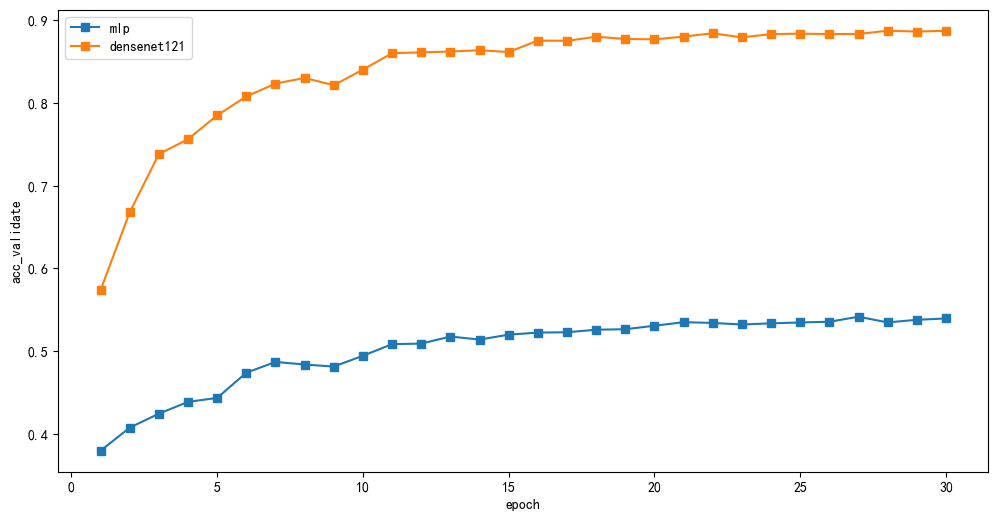

In [44]:
exec_result_mlp = exec_result.query('mode=="MLP" & layer_count==3 & active_function=="ReLU" & optimizer_function=="SGD"')
exec_result_densenet = exec_result.query('mode=="DenseNet" & layer_count=="[6, 12, 24, 16]" & active_function=="ReLU" & optimizer_function=="SGD"')
plt.figure(figsize=(12,6), dpi=100)
plt.rcParams['font.sans-serif']=['SimHei']
plt.plot(range(1,len(exec_result_mlp)+1),exec_result_mlp['acc_validate'], marker='s', label ='mlp')
plt.plot(range(1,len(exec_result_densenet)+1),exec_result_densenet['acc_validate'], marker='s', label ='densenet121')
plt.xlabel('epoch')
plt.ylabel('acc_validate')
plt.legend()

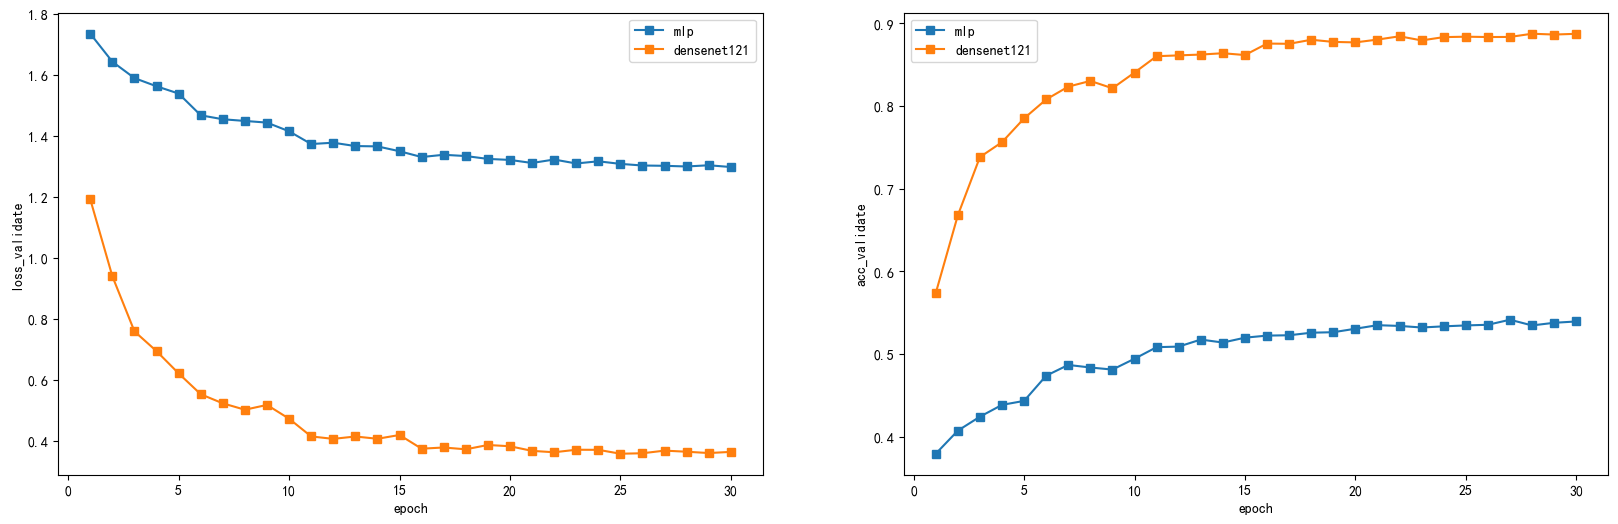

In [60]:
exec_result_mlp = exec_result.query('mode=="MLP" & layer_count==3 & active_function=="ReLU" & optimizer_function=="SGD"')
exec_result_densenet = exec_result.query('mode=="DenseNet" & layer_count=="[6, 12, 24, 16]" & active_function=="ReLU" & optimizer_function=="SGD"')
plt.figure(figsize=(20,6), dpi=100)
plt.rcParams['font.sans-serif']=['SimHei']
plt.subplot(121)
plt.plot(range(1,len(exec_result_mlp)+1),exec_result_mlp['loss_validate'], marker='s', label ='mlp')
plt.plot(range(1,len(exec_result_densenet)+1),exec_result_densenet['loss_validate'], marker='s', label ='densenet121')
plt.xlabel('epoch')
plt.ylabel('loss_validate')
plt.legend()
plt.subplot(122)
plt.plot(range(1,len(exec_result_mlp)+1),exec_result_mlp['acc_validate'], marker='s', label ='mlp')
plt.plot(range(1,len(exec_result_densenet)+1),exec_result_densenet['acc_validate'], marker='s', label ='densenet121')
plt.xlabel('epoch')
plt.ylabel('acc_validate')
plt.legend()
plt.show()

### 5.2 激活函数类型对结果的影响


使用CrossEntropyLoss损失函数+优化器SGD+动量计算，观测ReLU和Sigmoid激活函数对结果的影响：

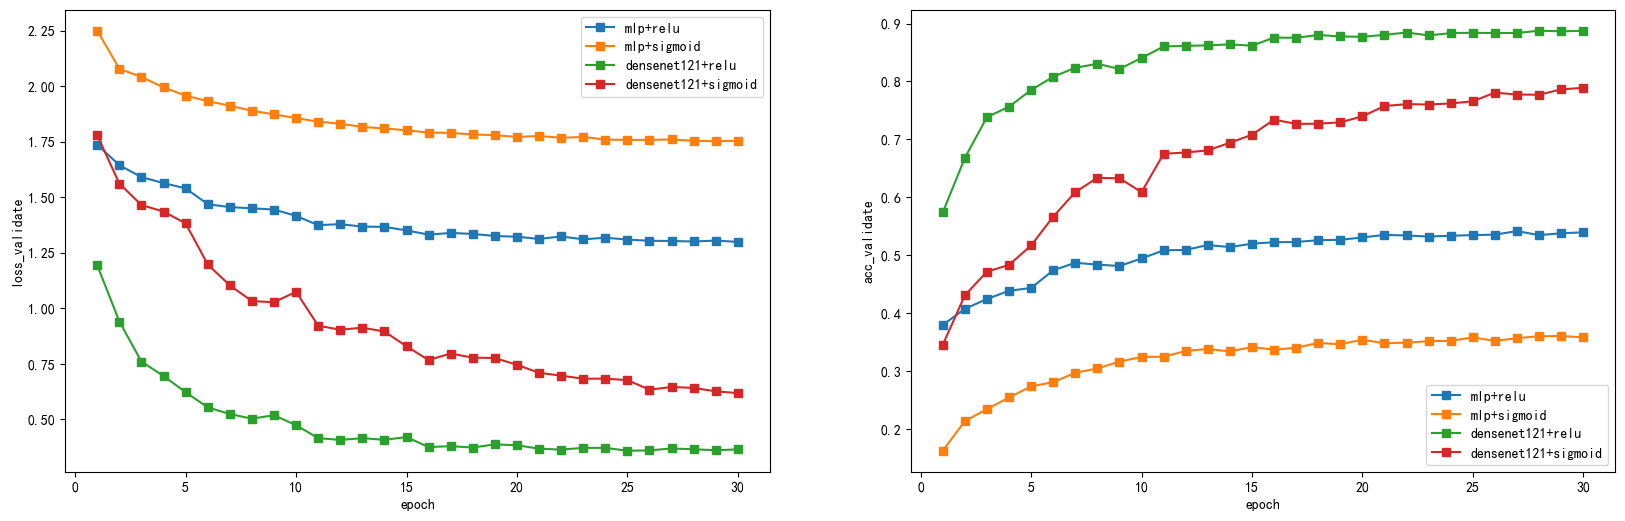

In [62]:
exec_result_mlp_relu = exec_result.query('mode=="MLP" & layer_count==3 & active_function=="ReLU" & optimizer_function=="SGD"')
exec_result_mlp_sigmoid = exec_result.query('mode=="MLP" & layer_count==3 & active_function=="Sigmoid" & optimizer_function=="SGD"')
exec_result_densenet_relu = exec_result.query('mode=="DenseNet" & layer_count=="[6, 12, 24, 16]" & active_function=="ReLU" & optimizer_function=="SGD"')
exec_result_densenet_sigmoid = exec_result.query('mode=="DenseNet" & layer_count=="[6, 12, 24, 16]" & active_function=="Sigmoid" & optimizer_function=="SGD"')
plt.figure(figsize=(20,6), dpi=100)
plt.rcParams['font.sans-serif']=['SimHei']
plt.subplot(121)
plt.plot(range(1,len(exec_result_mlp_relu)+1),exec_result_mlp_relu['loss_validate'], marker='s', label ='mlp+relu')
plt.plot(range(1,len(exec_result_mlp_sigmoid)+1),exec_result_mlp_sigmoid['loss_validate'], marker='s', label ='mlp+sigmoid')
plt.plot(range(1,len(exec_result_densenet_relu)+1),exec_result_densenet_relu['loss_validate'], marker='s', label ='densenet121+relu')
plt.plot(range(1,len(exec_result_densenet_sigmoid)+1),exec_result_densenet_sigmoid['loss_validate'], marker='s', label ='densenet121+sigmoid')
plt.xlabel('epoch')
plt.ylabel('loss_validate')
plt.legend()
plt.subplot(122)
plt.plot(range(1,len(exec_result_mlp_relu)+1),exec_result_mlp_relu['acc_validate'], marker='s', label ='mlp+relu')
plt.plot(range(1,len(exec_result_mlp_sigmoid)+1),exec_result_mlp_sigmoid['acc_validate'], marker='s', label ='mlp+sigmoid')
plt.plot(range(1,len(exec_result_densenet_relu)+1),exec_result_densenet_relu['acc_validate'], marker='s', label ='densenet121+relu')
plt.plot(range(1,len(exec_result_densenet_sigmoid)+1),exec_result_densenet_sigmoid['acc_validate'], marker='s', label ='densenet121+sigmoid')
plt.xlabel('epoch')
plt.ylabel('acc_validate')
plt.legend()
plt.show()

### 5.3 优化器对结果的影响


还是在默认参数下，使用ReLU激活函数+CrossEntropyLoss损失函数，优化器SGD+动量计算，观测优化器SGD和Adam对结果的影响：

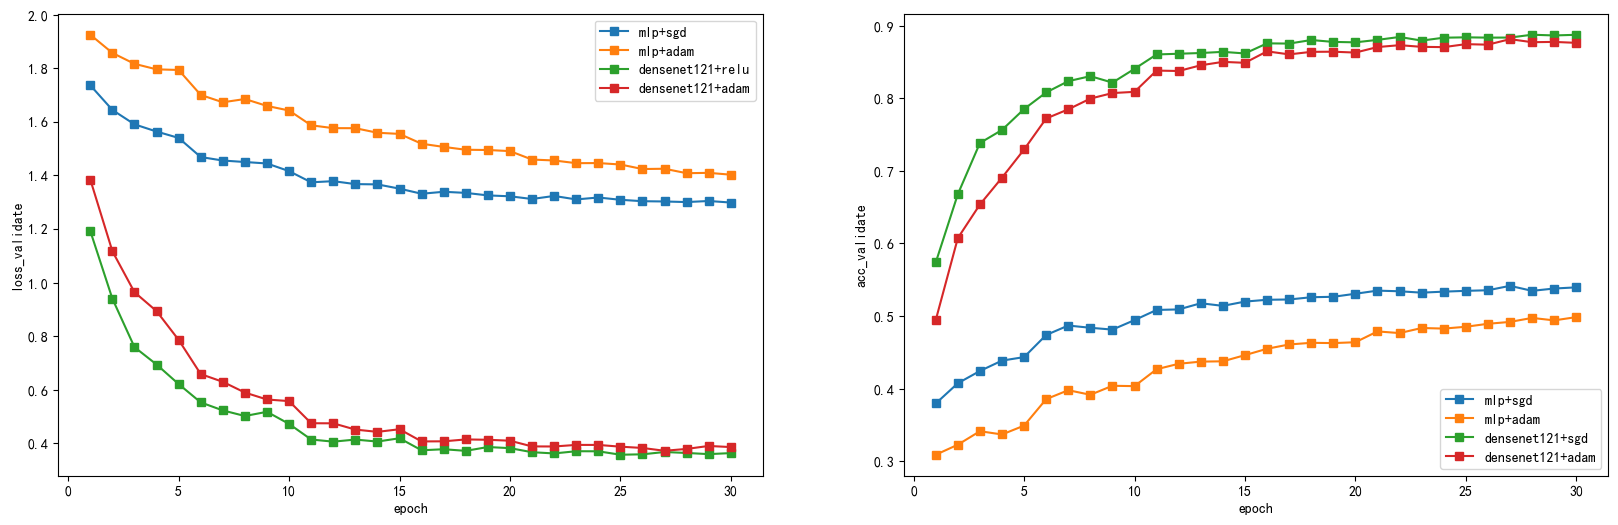

In [63]:
exec_result_mlp_sgd = exec_result.query('mode=="MLP" & layer_count==3 & active_function=="ReLU" & optimizer_function=="SGD"')
exec_result_mlp_adam = exec_result.query('mode=="MLP" & layer_count==3 & active_function=="ReLU" & optimizer_function=="Adam"')
exec_result_densenet_sgd = exec_result.query('mode=="DenseNet" & layer_count=="[6, 12, 24, 16]" & active_function=="ReLU" & optimizer_function=="SGD"')
exec_result_densenet_adam = exec_result.query('mode=="DenseNet" & layer_count=="[6, 12, 24, 16]" & active_function=="ReLU" & optimizer_function=="Adam"')
plt.figure(figsize=(20,6), dpi=100)
plt.rcParams['font.sans-serif']=['SimHei']
plt.subplot(121)
plt.plot(range(1,len(exec_result_mlp_sgd)+1),exec_result_mlp_sgd['loss_validate'], marker='s', label ='mlp+sgd')
plt.plot(range(1,len(exec_result_mlp_adam)+1),exec_result_mlp_adam['loss_validate'], marker='s', label ='mlp+adam')
plt.plot(range(1,len(exec_result_densenet_sgd)+1),exec_result_densenet_sgd['loss_validate'], marker='s', label ='densenet121+relu')
plt.plot(range(1,len(exec_result_densenet_adam)+1),exec_result_densenet_adam['loss_validate'], marker='s', label ='densenet121+adam')
plt.xlabel('epoch')
plt.ylabel('loss_validate')
plt.legend()
plt.subplot(122)
plt.plot(range(1,len(exec_result_mlp_sgd)+1),exec_result_mlp_sgd['acc_validate'], marker='s', label ='mlp+sgd')
plt.plot(range(1,len(exec_result_mlp_adam)+1),exec_result_mlp_adam['acc_validate'], marker='s', label ='mlp+adam')
plt.plot(range(1,len(exec_result_densenet_sgd)+1),exec_result_densenet_sgd['acc_validate'], marker='s', label ='densenet121+sgd')
plt.plot(range(1,len(exec_result_densenet_adam)+1),exec_result_densenet_adam['acc_validate'], marker='s', label ='densenet121+adam')
plt.xlabel('epoch')
plt.ylabel('acc_validate')
plt.legend()
plt.show()

### 5.4 层数对结果的影响

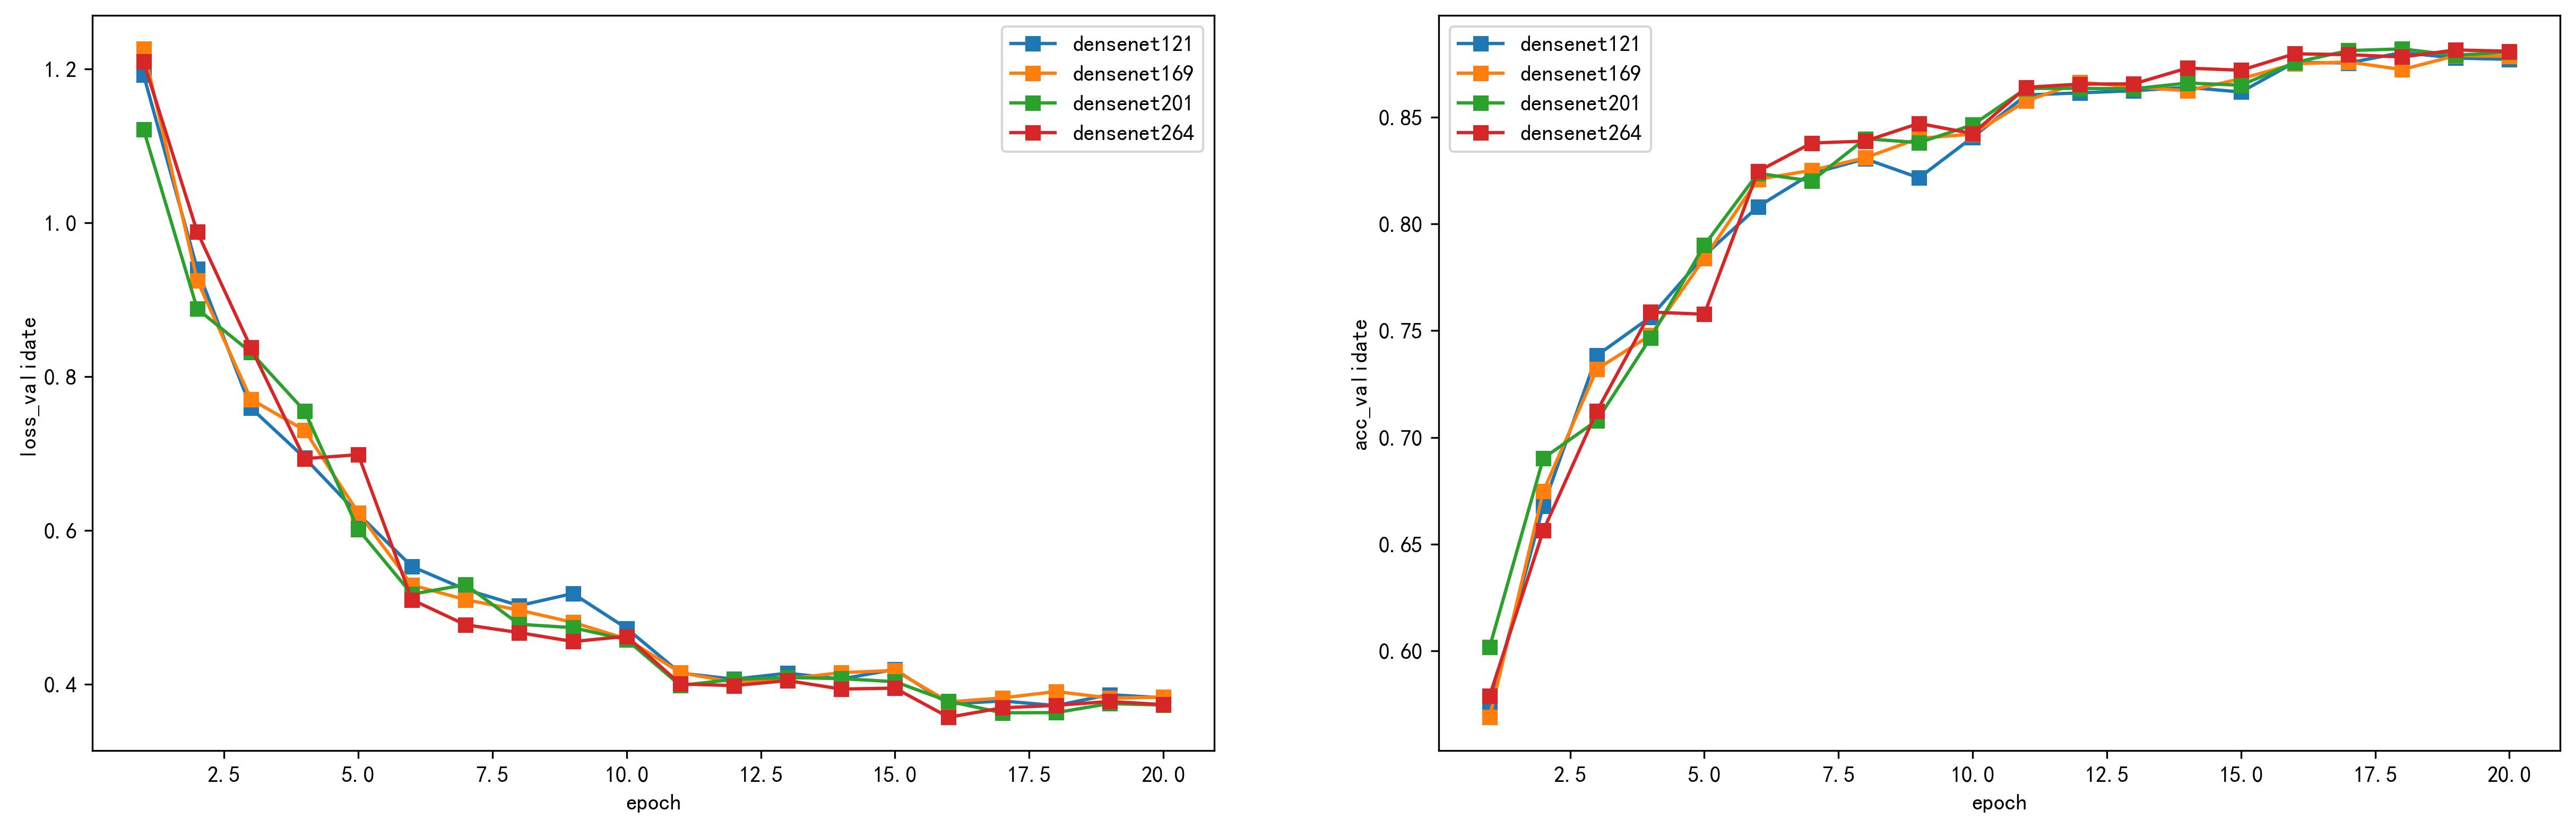

In [75]:
exec_result_densenet121 = exec_result.query('mode=="DenseNet" & layer_count=="[6, 12, 24, 16]" & active_function=="ReLU" & optimizer_function=="SGD" & epoch <=20')
exec_result_densenet169 = exec_result.query('mode=="DenseNet" & layer_count=="[6, 12, 32, 32]" & active_function=="ReLU" & optimizer_function=="SGD" & epoch <=20')
exec_result_densenet201 = exec_result.query('mode=="DenseNet" & layer_count=="[6, 12, 48, 32]" & active_function=="ReLU" & optimizer_function=="SGD" & epoch <=20')
exec_result_densenet264 = exec_result.query('mode=="DenseNet" & layer_count=="[6, 12, 64, 48]" & active_function=="ReLU" & optimizer_function=="SGD" & epoch <=20')
plt.figure(figsize=(20,6), dpi=300)
plt.rcParams['font.sans-serif']=['SimHei']
plt.subplot(121)
plt.plot(range(1,len(exec_result_densenet121)+1),exec_result_densenet121['loss_validate'], marker='s', label ='densenet121')
plt.plot(range(1,len(exec_result_densenet169)+1),exec_result_densenet169['loss_validate'], marker='s', label ='densenet169')
plt.plot(range(1,len(exec_result_densenet201)+1),exec_result_densenet201['loss_validate'], marker='s', label ='densenet201')
plt.plot(range(1,len(exec_result_densenet264)+1),exec_result_densenet264['loss_validate'], marker='s', label ='densenet264')
plt.xlabel('epoch')
plt.ylabel('loss_validate')
plt.legend()
plt.subplot(122)
plt.plot(range(1,len(exec_result_densenet121)+1),exec_result_densenet121['acc_validate'], marker='s', label ='densenet121')
plt.plot(range(1,len(exec_result_densenet169)+1),exec_result_densenet169['acc_validate'], marker='s', label ='densenet169')
plt.plot(range(1,len(exec_result_densenet201)+1),exec_result_densenet201['acc_validate'], marker='s', label ='densenet201')
plt.plot(range(1,len(exec_result_densenet264)+1),exec_result_densenet264['acc_validate'], marker='s', label ='densenet264')
plt.xlabel('epoch')
plt.ylabel('acc_validate')
plt.legend()
plt.show()

In [73]:
exec_result.query('mode=="DenseNet" & active_function=="ReLU" & optimizer_function=="SGD"').groupby(['layer_count'])['acc_validate'].agg([('max_acc_validate','max')]).reset_index()

,layer_count,max_acc_validate
0,"[6, 12, 24, 16]",0.8876
1,"[6, 12, 32, 32]",0.8819
2,"[6, 12, 48, 32]",0.8820
3,"[6, 12, 64, 48]",0.8815


In [74]:
exec_result.query('mode=="DenseNet" & active_function=="ReLU" & optimizer_function=="SGD"').groupby(['layer_count'])['time'].agg([('sum_time','sum')]).reset_index()

,layer_count,sum_time
0,"[6, 12, 24, 16]",2724.855211
1,"[6, 12, 32, 32]",2720.986817
2,"[6, 12, 48, 32]",3384.007614
3,"[6, 12, 64, 48]",5047.910030


### 5.5 最佳模型

In [77]:
best_index = exec_result['acc_validate'].idxmax()
auc_best= exec_result.loc[best_index]
auc_best

mode                          DenseNet
layer_count            [6, 12, 24, 16]
epoch                               28
batch_size                          16
active_function                   ReLU
loss_function         CrossEntropyLoss
optimizer_function                 SGD
lr                            0.000031
weight_decay                    0.0001
time                         92.192072
loss_train                    0.128567
loss_validate                 0.364503
acc_train                     0.958625
acc_validate                    0.8876
acc_test                             0
remark                                
Name: 267, dtype: object

In [86]:
model =torch.load('./result/best_model_rensenet.pt')
# 测试
with torch.no_grad():
    model.eval()
    correct = 0
    total = 0
    for (images, labels) in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
    print("The accuracy of test: {:6f}".format(correct / total))
    auc_best['acc_test'] =correct / total

The accuracy of test: 0.884800


/tmp/ipykernel_175044/3116151351.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auc_best['acc_test'] =correct / total
